# Experiments

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image
from IPython.core.display import HTML 

Data Science is an iterative process. You start with a hypothesis, test and adjust. 

First lets reiterate the Objective:
    
- GIVEN: A single low dose CT scan from a lung cancer 
         screening participant
-  TASK: Predict if this subject was diagnosed with lung cancer within 
one year of the CT scan
    

There is a zoo of models out there and now we have a Cambrian Explosion of
AI models. The Automated CADe business has been around since the turn of 
century. The **ANODE09** event is a summary.

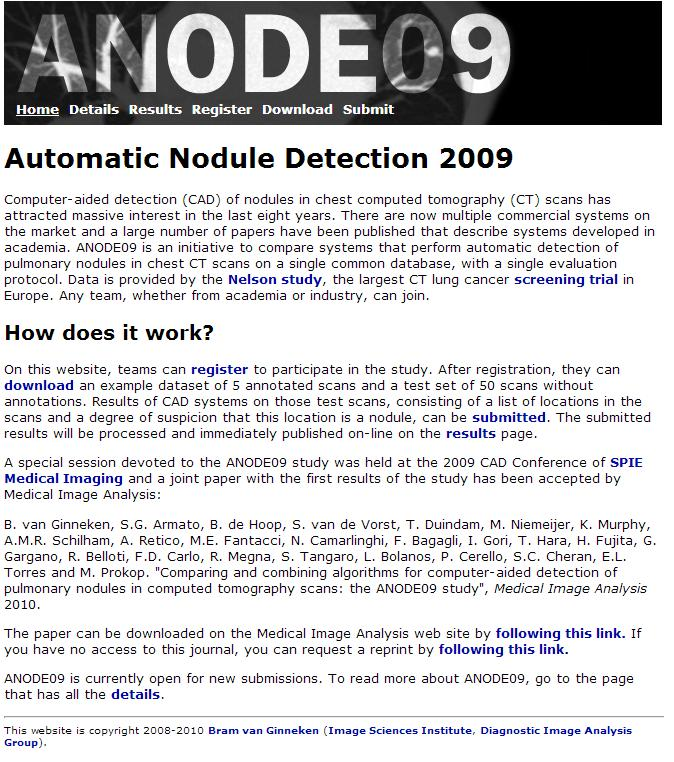

In [2]:
img ="../images/anode09.jpg"
Image(filename= img, width=450, height=500)

As of 2017 the DeepLearning Models are giving the results in computer vision. So we will start here.

## Initial Observations

The naive approach of taking an image and feed it into the network doesnt
work !!

- First, there is the **needle** in a haystack **problem**. 
The radius of the average malicious nodule in the LUNA dataset is 4.8 mm and a 
typical CT scan captures a volume of 512mm x 512mm x 512mm. So we are
looking for a feature that is almost a million times smaller than the 
input volume. Moreover, this feature determines the classification 
of the **whole** input volume. Moreover the CT scan is from a patient 
that will be diagnosed with lung cancer within one year of the date 
the scan was taken. The module may not even be there now!!


 Baseline, Year 0


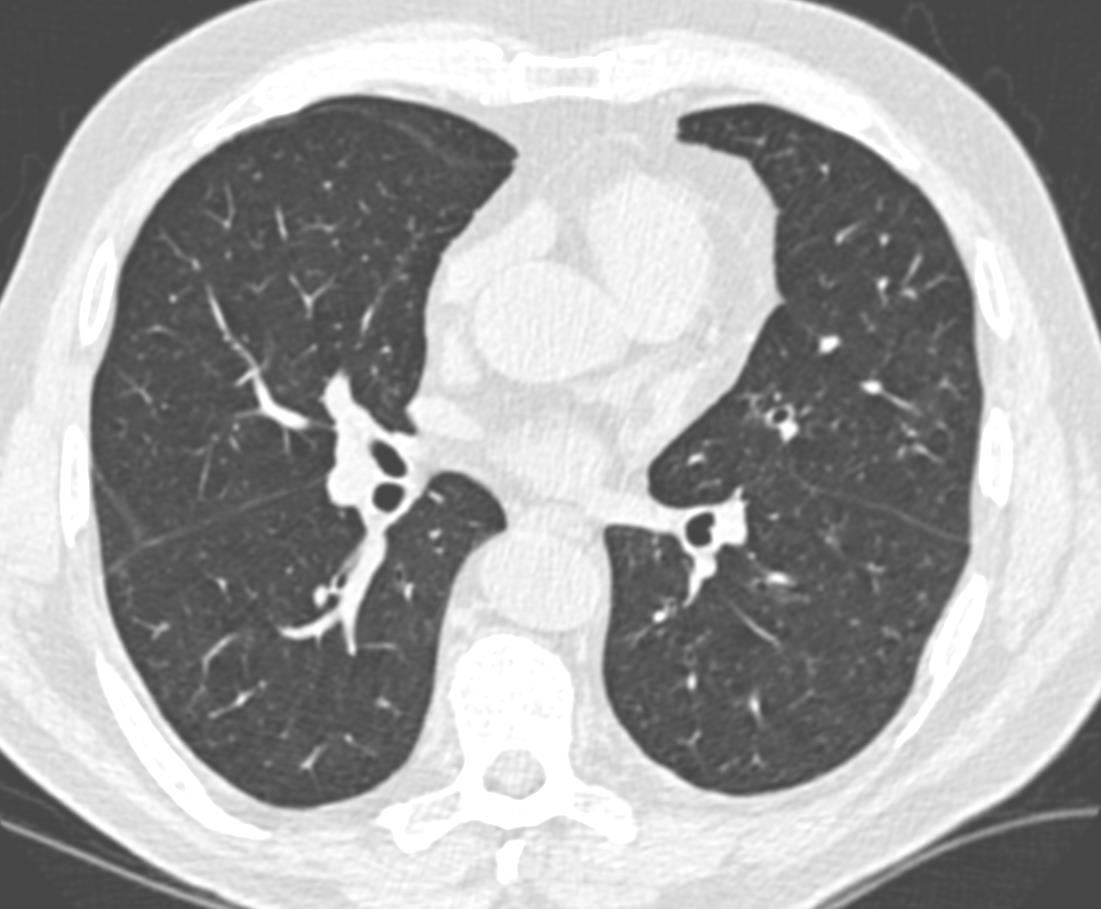

In [3]:
print(' Baseline, Year 0')
img ="../images/s0.jpg"
Image(filename= img, width=450, height=500)

After Year 1 6mm


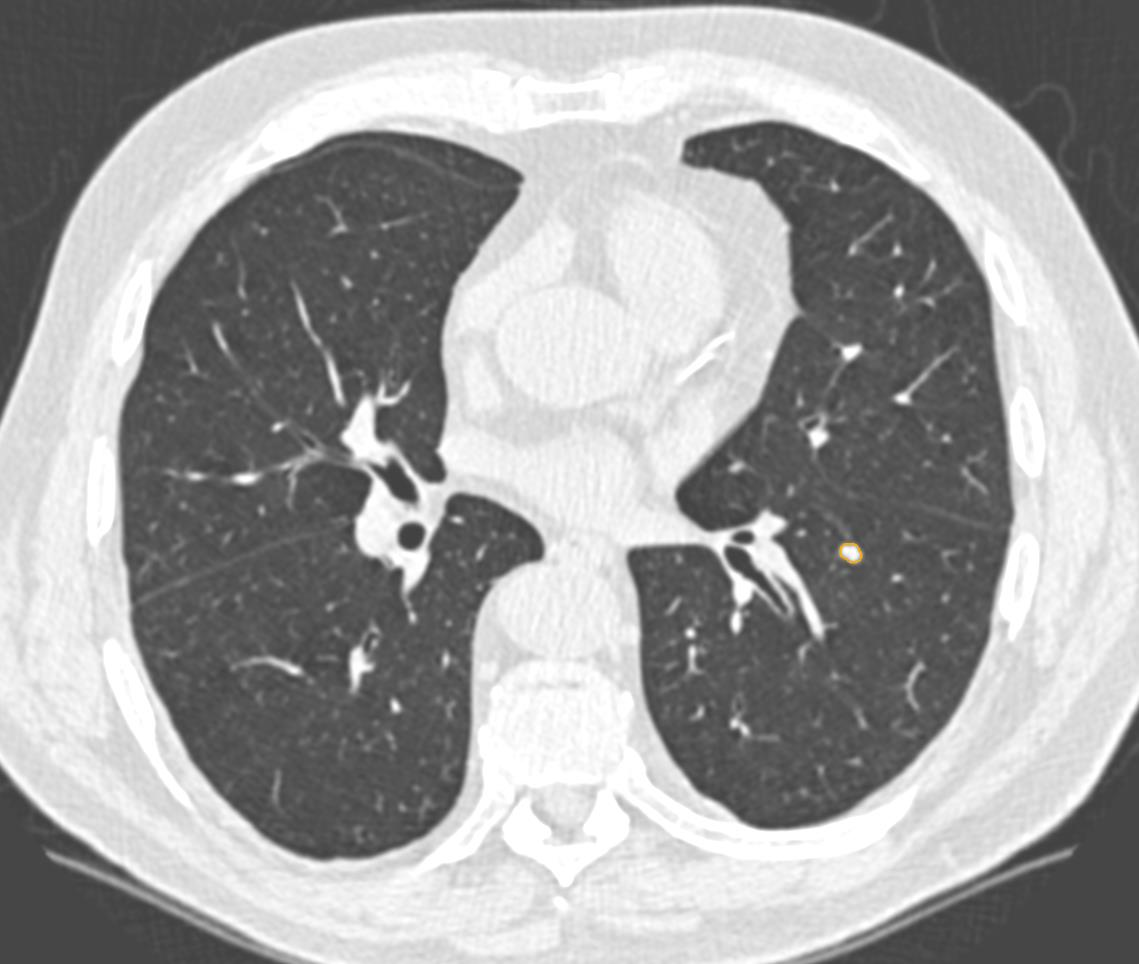

In [4]:
print( 'After Year 1', '6mm')
img ="../images/s1.jpg"
Image(filename= img, width=450, height=500)

After Year 2 2mm


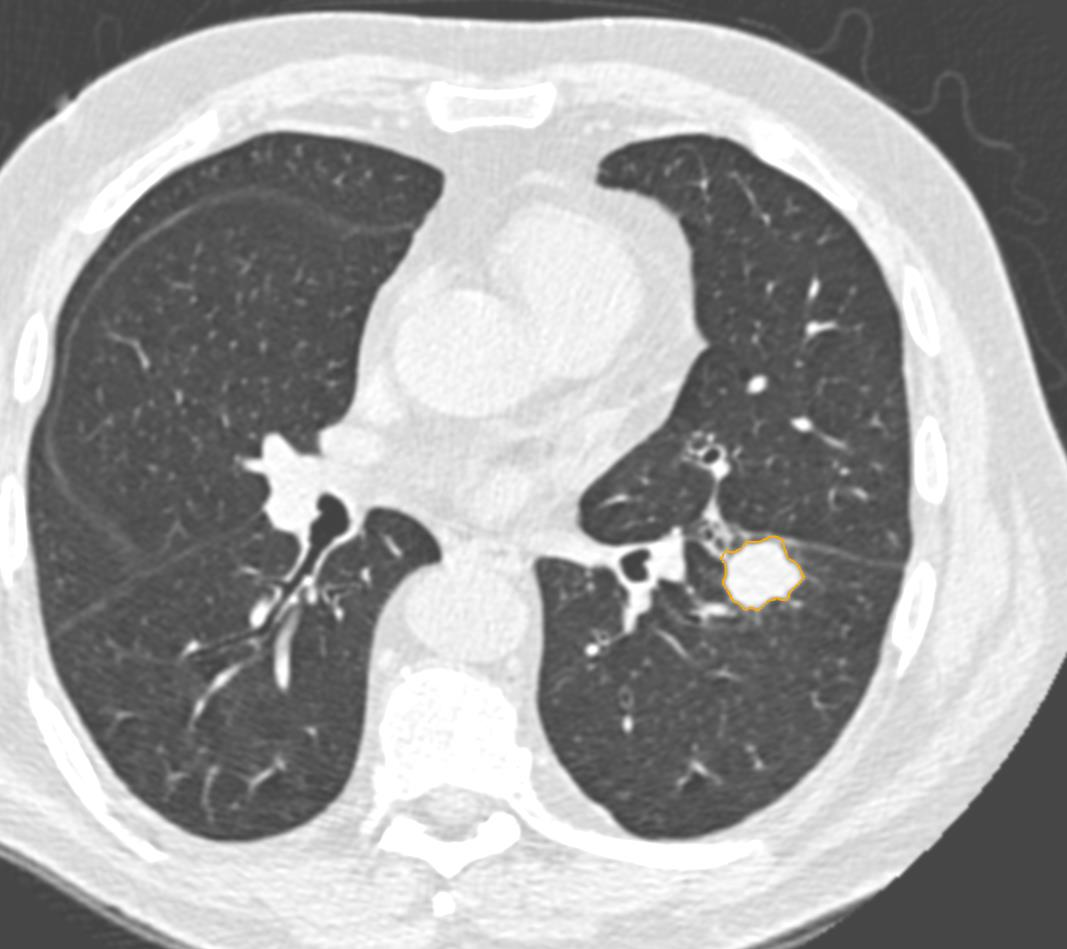

In [5]:
print( 'After Year 2', '2mm')
img ="../images/s2.jpg"
Image(filename= img, width=450, height=500)

- Since the nodule segmentation network could not see a global 
  context,   it produced many false positives outside the lungs,
  which were picked up in the later stages.


- What if you have many pockets of air in the intestines

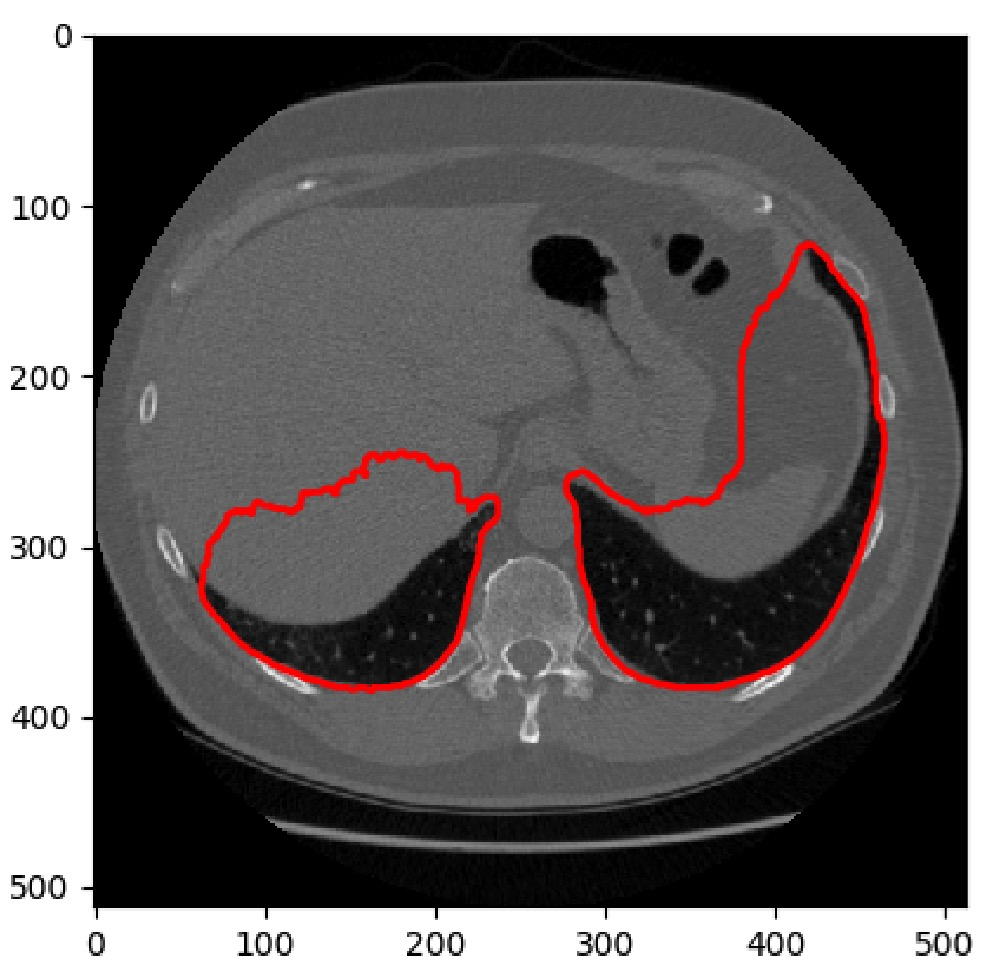

In [6]:
img ="../images/air_intestines.jpg"
Image(filename= img, width=450, height=500)

- This is a zoo! Can you honest to God segment all of these types reliably ?? 

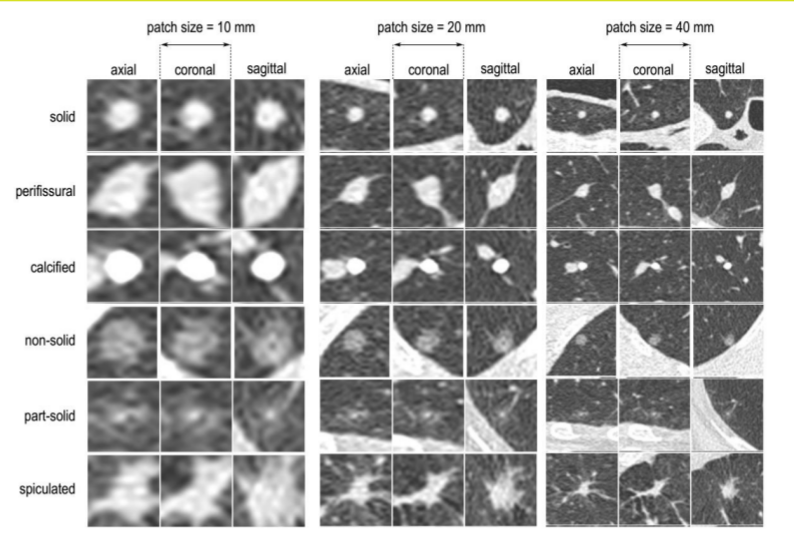

In [7]:
img ="../images/diversity.png"
Image(filename= img, width=500, height=500)

## Move to 3D Convnet detection of nodules

**Change Solution Space**:
- We want to be able to take advantage of 3D morphology and 
   spacial relationships
- We want some human explainability of out model
- So we choose a 3D Hybrid Convnet


 **Change Problem**:
 
- Look for suspicious nodules
- Estimate probability of malignancy for the most suspicious nodule(s)

For this demo :
    We break each scan up into 64X64X64 cubes and train a 3D convnet to
    predict whether or not there is a nodule in this volume. 

# Demo Example 

In [8]:
from __future__ import print_function

import argparse
import os
from glob import glob

import numpy as np
from keras import backend as bck_end
from keras.layers import Dense, Flatten
from keras.layers import Input, Convolution3D, BatchNormalization, MaxPooling3D
from keras.models import Model
from keras.optimizers import Adam


Using TensorFlow backend.


In [9]:
from itkwidgets import view
import itk
import VisualTools
from VisualTools import visualtools

from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


# The 3D Model

In [19]:
# %load code/threeD_convnet.py
from __future__ import print_function

from keras import backend
from keras.layers import Dense, Flatten
from keras.layers import Input, Convolution3D, BatchNormalization, MaxPooling3D
from keras.models import Model
from keras.optimizers import Adam

backend.set_image_dim_ordering('th')  # Theano dimension ordering in this code

num_filters = [16, 32, 64, 128, 256, 1028]


def get_simp3d(lr=4e-5):
    inputs = Input((1, 64, 64, 64))
    conv1 = Convolution3D(num_filters[0], (9, 9, 9), activation='relu', padding='valid')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution3D(num_filters[0],( 3, 3, 3), activation='relu', padding='valid')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution3D(num_filters[0],( 5, 5, 5), activation='relu', padding='valid')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Convolution3D(num_filters[1], (3, 3, 3), activation='relu', padding='valid')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Convolution3D(num_filters[1], (3, 3, 3), activation='relu', padding='valid')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Convolution3D(num_filters[2], (3, 3, 3), activation='relu', padding='valid')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Convolution3D(num_filters[2], (3, 3, 3), activation='relu', padding='valid')(conv3)
    conv3 = BatchNormalization()(conv3)

    conv4 = Convolution3D(num_filters[3], (3, 3, 3), activation='relu', padding='valid')(conv3)
    conv4 = BatchNormalization()(conv4)

    flat = Flatten()(conv4)

    dense6 = Dense(units=256, activation='relu')(flat)
    dense6 = BatchNormalization()(dense6)
    dense7 = Dense(units=2, activation='softmax')(dense6)

    model = Model(inputs=inputs, outputs=dense7 )

    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_crossentropy'])

    return model


# PreProcess

First segmentation! I have outlined some of the difficulties above.

- You will use standard Erosion, Dilation, Closing, Opening but 
  in addition you need Watershed thresholding because cells are 
  connected to wall and Region Growing Algorithms.

- Sometimes nodules look like blood vessels.

- Nodules come in different varieties.

- Large air pockets not always in lungs


In [12]:

import os
import sys
from glob import glob

import SimpleITK as sitk
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.ndimage
from keras import backend as K
from tqdm import tqdm

K.set_image_dim_ordering('tf')


# Some helper functions

def matrix2int16(matrix):
    '''
    matrix must be a numpy array NXN
    Returns uint16 version
    '''
    m_min = np.min(matrix)
    m_max = np.max(matrix)
#     print(m_min, m_max)
    matrix = matrix - m_min
    return np.array(np.rint(matrix / float(m_max - m_min) * 65535.0), dtype=np.uint16)


def make_mask(center, diam, z, width, height, spacing, origin):
    '''
    Center : centers of circles px -- list of coordinates x,y,z
    diam : diameters of circles px -- diameter
    widthXheight : pixel dim of image
    spacing = mm/px conversion rate np array x,y,z
    origin = x,y,z mm np.array
    z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height, width])  # 0's everywhere except nodule swapping x,y to match img
    # convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center - origin) / spacing
    v_diam = int(diam / spacing[0] + 5)
    v_xmin = np.max([0, int(v_center[0] - v_diam) - 5])
    v_xmax = np.min([width - 1, int(v_center[0] + v_diam) + 5])
    v_ymin = np.max([0, int(v_center[1] - v_diam) - 5])
    v_ymax = np.min([height - 1, int(v_center[1] + v_diam) + 5])

    v_xrange = range(v_xmin, v_xmax + 1)
    v_yrange = range(v_ymin, v_ymax + 1)

    # Convert back to world coordinates for distance calculation
    x_data = [x * spacing[0] + origin[0] for x in range(width)]
    y_data = [x * spacing[1] + origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0] * v_x + origin[0]
            p_y = spacing[1] * v_y + origin[1]
            if np.linalg.norm(center - np.array([p_x, p_y, z])) <= diam and abs(center[2]-z)<diam/2.5:
                mask[int((p_y - origin[1]) / spacing[1]), int((p_x - origin[0]) / spacing[0])] = 1.0
    return mask.astype(np.uint8)


#####################
#

# Load the scans in given folder path
class Dicom_ersatz:
    def __init__(self, spacing, pixel_array, direction, mask_array=None):
        if mask_array is None:
            mask_array = []
        self.SliceThickness = spacing[2]
        self.pixel_array = pixel_array
        self.PixelSpacing = list(spacing[:2])
        self.direction = direction
        self.mask_array = mask_array


def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image < -1548] = -1000
    image2 = np.zeros(image.shape, dtype=np.uint16)
    for n, im in enumerate(image):
        im = matrix2int16(im)
        image2[n, ...] = im

    return image2


def get_masks(scans):
    masks = np.stack([s.mask_array if s.direction[0] > 0 else s.mask_array.transpose() for s in scans])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    masks = masks.astype(np.int8)

    return masks


def resample(image, scan, new_spacing=None, crop=(0, 0)):
    # Determine current pixel spacing

    if new_spacing is None:
        new_spacing = [1, 1, 1]
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    #     print(resize_factor)
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    #     image = image[...,crop[0]:-crop[0], crop[1]:-crop[1]]
    return image, new_spacing


def load_scan(path, df_node):
    mini_df = df_node[df_node["file"] == path]  # get all nodules associate with file

    nodes = []
    for index, row in mini_df.iterrows():
        #         print(row)
        node_x = row["coordX"]
        node_y = row["coordY"]
        node_z = row["coordZ"]
        diam = row["diameter_mm"]
        nodes += [(node_x, node_y, node_z, diam)]

    # print(path)
    itk_img = sitk.ReadImage(path)
    slices_npy = sitk.GetArrayFromImage(itk_img)
    num_z, height, width = slices_npy.shape
    spacing = np.array(itk_img.GetSpacing())  # spacing of voxels in world coor. (mm)
    direction = np.array(itk_img.GetDirection())

    origin = np.array(itk_img.GetOrigin())
    slices = []

    for iz, s in enumerate(slices_npy):

        mask = np.zeros([height, width], dtype=np.uint8)

        for node in nodes:
            node2 = direction[0] * node[0], direction[0] * node[1], node[2], node[3]
            origin2 = direction[0] * origin[0], direction[0] * origin[1], origin[2]
            center = np.array([node2[0], node2[1], node2[2]])
            if direction[0] < 0:
                center[0], center[1] = center[1], center[0]

            diam = node2[3]
            mask += make_mask(center, diam, iz * spacing[2] + origin2[2], width, height, spacing, origin2)

        slices += [Dicom_ersatz(spacing, s, direction, mask)]

    tumor_coords = []
    for node in nodes:
        node2 = direction[0] * node[0], direction[0] * node[1], node[2], node[3]
        origin2 = direction[0] * origin[0], direction[0] * origin[1], origin[2]
        center = ((np.array([node2[0], node2[1], node2[2]]) - np.array(origin2)) / spacing).astype('int16')
        center[0], center[1] = center[1], center[0]
        diam = int(node[3] / spacing[0])
        tumor_coords += [(center, diam)]

    return slices, tumor_coords


def main(n_folders):
    for n_folder in n_folders:
        # Getting list of image files
        luna_path = "./luna/"

        luna_subset_path = luna_path + "subset{}/".format(n_folder)
        output_path = "./luna/preprocessed_3d/"
        file_list = glob(luna_subset_path + "*.mhd")
        print(len(file_list))

        # Helper function to get rows in data frame associated
        # with each file
        def get_filename(case):
            for f in file_list:
                if case in f:
                    return f
                
                
            # The locations of the nodes
        df_node = pd.read_csv(luna_path + "annotations.csv")
        df_node["file"] = df_node["seriesuid"].apply(get_filename)
        df_node = df_node.dropna()
        pad = 32
        
        for patient_file in tqdm(file_list):
            try:
                first_patient, tumor_info = load_scan(patient_file, df_node)

                first_patient_pixels = get_pixels_hu(first_patient)
                first_patient_masks = get_masks(first_patient)

                pix_resampled, spacing = resample(first_patient_pixels, first_patient,
                                                  [1.25, first_patient[0].PixelSpacing[0],
                                                   first_patient[0].PixelSpacing[1]])
                masks_resampled, spacing = resample(first_patient_masks, first_patient,
                                                    [1.25, first_patient[0].PixelSpacing[0],
                                                     first_patient[0].PixelSpacing[1]])

                ratio = float(first_patient_pixels.shape[0]) / pix_resampled.shape[0]
                #     print(ratio)
                #     print(pix_resampled.shape)
                #     print(first_patient_pixels.shape)

                #     print(tumor_info)
                # get 10 random cubes:
                print('found {} tumors'.format(len(tumor_info)))

                if not tumor_info:
                    x_rand = np.random.randint(50, 420, 10)
                    y_rand = np.random.randint(50, 420, 10)
                    z_rand = np.random.randint(32, pix_resampled.shape[0] - 32, 10)
                    for n_t, (x, y, z) in enumerate(zip(x_rand, y_rand, z_rand)):
                        tumor_cube = pix_resampled[z - pad:z + pad,
                                     x - pad: x + pad,
                                     y - pad: y + pad]
                        mask_cube = masks_resampled[z - pad:z + pad,
                                    x - pad: x + pad,
                                    y - pad: y + pad]

                        #             for im, mask in zip(tumor_cube, mask_cube):

                        #                 plt.imshow(im, cmap=plt.cm.gray)
                        #                 plt.imshow(mask, cmap=plt.cm.cool, alpha=0.2)
                        #                 plt.show()

                        np.save(output_path + 
                                f'cube_scans_neg_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                                tumor_cube)

                else: 
                    x_rand = np.random.randint(50, 420, 5)
                    y_rand = np.random.randint(50, 420, 5)
                    z_rand = np.random.randint(50, pix_resampled.shape[0] - 50, 5)
                    for n_t, (x, y, z) in enumerate(zip(x_rand, y_rand, z_rand)):
                        tumor_cube = pix_resampled[z - pad:z + pad,
                                     x - pad: x + pad,
                                     y - pad: y + pad]
                        mask_cube = masks_resampled[z - pad:z + pad,
                                    x - pad: x + pad,
                                    y - pad: y + pad]

                        np.save(output_path + 
                                f'cube_scans_neg_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                                tumor_cube)
                    #             for im, mask in zip(tumor_cube, mask_cube):

                        #                 plt.imshow(im, cmap=plt.cm.gray)
                        #                 plt.imshow(mask, cmap=plt.cm.cool, alpha=0.2)
                        #                 plt.show()

                for n_t, tumor in tqdm(enumerate(tumor_info)):
                    tumor_coords = tumor[0]
                    tumor_coords[2] = int(tumor_coords[2] / ratio)
                    r_offset = np.random.randint(-16, 16)

                    tumor_cube = pix_resampled[tumor_coords[2] + r_offset - pad:tumor_coords[2] + r_offset + pad,
                                 tumor_coords[0] + r_offset - pad: tumor_coords[0] + r_offset + pad,
                                 tumor_coords[1] + r_offset - pad: tumor_coords[1] + r_offset + pad]
                    mask_cube = masks_resampled[tumor_coords[2] + r_offset - pad:tumor_coords[2] + r_offset + pad,
                                tumor_coords[0] + r_offset - pad: tumor_coords[0] + r_offset + pad,
                                tumor_coords[1] + r_offset - pad: tumor_coords[1] + r_offset + pad]

                    np.save(output_path + f'cube_scans_pos_0_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                            tumor_cube)
                    np.save(output_path + f'cube_scans_pos_0_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                            mask_cube)


                    r_offset = np.random.randint(-16, 16)

                    tumor_cube = pix_resampled[tumor_coords[2] + r_offset - pad:tumor_coords[2] + r_offset + pad,
                                 tumor_coords[0] + r_offset - pad: tumor_coords[0] + r_offset + pad,
                                 tumor_coords[1] + r_offset - pad: tumor_coords[1] + r_offset + pad]
                    mask_cube = masks_resampled[tumor_coords[2] + r_offset - pad:tumor_coords[2] + r_offset + pad,
                                tumor_coords[0] + r_offset - pad: tumor_coords[0] + r_offset + pad,
                                tumor_coords[1] + r_offset - pad: tumor_coords[1] + r_offset + pad]

                    np.save(output_path + f'cube_scans_pos_1_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                            tumor_cube)
                    np.save(output_path + f'cube_scans_pos_1_{n_t}_{os.path.basename(patient_file)[:-4]}.npy',
                            mask_cube)


            except Exception as e:
                print(e)
            
if __name__ == '__main__':
    args = [int(i) for i in sys.argv[1:]]
    #print(args)
    main(args)         
                          

ValueError: invalid literal for int() with base 10: '-f'

## Cubic (64X64X64) sections of scan

In [20]:
im_p= '../data/cubes/' + 'cube_scans_neg_0_1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.npy'

In [21]:
arr=np.load(im_p)
view(arr)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUS3; proxy …

In [22]:
visualtools.slice_explorer(arr)

interactive(children=(IntSlider(value=34, description='plane', max=63), Output()), _dom_classes=('widget-inter…

<function VisualTools.visualtools.slice_explorer.<locals>.display_slice(plane=34)>

# Predict on a cube

In [23]:
new_model = get_simp3d(lr=4e-5);

W0728 21:57:19.190686 140349008594752 deprecation_wrapper.py:119] From /home/yxs8495/miniconda3/envs/theano3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 21:57:19.191778 140349008594752 deprecation_wrapper.py:119] From /home/yxs8495/miniconda3/envs/theano3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0728 21:57:20.389891 140349008594752 deprecation_wrapper.py:119] From /home/yxs8495/miniconda3/envs/theano3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [24]:
new_model.load_weights('./weights/extra_data_weigths_3dconv_3_best.h5')

In [25]:
#path= os.getcwd();
path= '../data/cubes/'
list=os.listdir('../data/cubes')
img = path + list[1]
arr= np.load(img);
arr=np.expand_dims(arr, axis=0);
arr=np.expand_dims(arr, axis=0);
pred = new_model.predict(arr);

pred

array([[0.9850818 , 0.01491816]], dtype=float32)